# Amazon reviews helpfulness

This notebook presents an analysis of the dataset of reviews coming from Amazon shopping service. The dataset contains over 270k records with following fields:
- `asin` - product ID,
- `helpful` - list of votes [thumbs up, total votes],
- `overall` - rate gave by the user, 
- `reviewerName` - name of the reviewer,
- `reviewerID` - ID of the reviewer,
- `summary` - summary of the review,
- `reviewText` - full text of the review,
- `reviewTime` - timestamp of the review,
- `unixReviewTime` - raw timestamp of the review.

First step is to load the data and have a look on the data table.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Clothing_Shoes_and_Jewelry_5.csv')
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


It is immediately visible that some of the records have no votes regarding their helpfulness. Because of that they won't be helpful in building the model for inferencing a review helpfulness. In the next step some data pre-processing will be performed so exploratory analysis can be performed

## Data pre-processing
In this step some clearning and feature extraction will be performed.

In [16]:
def transform_helpful_scores(scores):
    """Transform helpful scores string to separate columns of numbers."""
    ups, downs = scores.lstrip('[').rstrip(']').split(', ')
    return pd.Series([int(ups), int(downs)])

# Transform helpful scores into columns.
df.helpful.fillna('[0, 0]', inplace=True)
df[['helpfulUp', 'helpfulTotal']] = df.helpful.apply(transform_helpful_scores)
# Extract reviewTextLength from reviewText.
df.reviewText.fillna('', inplace=True)
df['reviewTextLength'] = df.reviewText.apply(lambda x: len(x.split(' ')))
# Extract summaryLength from summary.
df.fillna('', inplace=True)
df['summaryLength'] = df.summary.apply(lambda x: len(x.split(' ')))

## Exploratory analysis

In [18]:
print("Total records: ", len(df))
print("Records with helpful votes: ", len(df[df.helpfulTotal > 0]))

Total records:  278677
Records with helpful votes:  87021


In the next part of the assignment I will only consider records with helpful votes. It will make the analysis easier at this stage.

In [19]:
df = df[df.helpfulTotal > 0]

count    87021.000000
mean         4.305961
std         12.100381
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1267.000000
Name: helpfulTotal, dtype: float64
count    87021.000000
mean         3.669758
std         11.374755
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1200.000000
Name: helpfulUp, dtype: float64


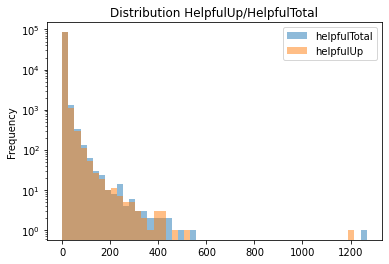

In [20]:
df[['helpfulTotal', 'helpfulUp']].plot.hist(
    bins=50, log=True, alpha=0.5, title="Distribution HelpfulUp/HelpfulTotal",
)
print(df.helpfulTotal.describe())
print(df.helpfulUp.describe())

The majority of the reviews have relatively small number of helpful votes. Most of the comments never reach above 200 votes. There is also one comment that got significantly more votes(over 1200) and it might be an outlier in this dataset. It might be worth considering to only build a model using reviews with significant number of votes as it may lead to more robust results. However in this assignment I will follow with the data I have now.

count    87021.000000
mean        81.033268
std         86.150385
min          1.000000
25%         32.000000
50%         55.000000
75%         97.000000
max       3926.000000
Name: reviewTextLength, dtype: float64


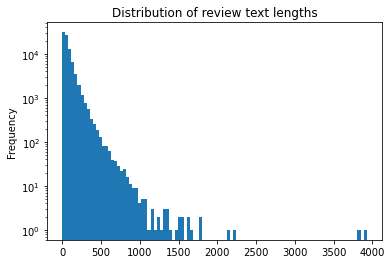

In [21]:
df.reviewTextLength.plot.hist(
    bins=100, log=True, title="Distribution of review text lengths"
)
print(df.reviewTextLength.describe())

Similarly to the amount of votes majority of reviews are quite short. There's a lot of them that have only one or two words. There are also two extremely long reviews. Both of them are authored by one person. 

In [22]:
df[df.reviewTextLength > 3000]

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpfulUp,helpfulTotal,reviewTextLength,summaryLength
63437,B001F50G8K,"[31, 33]",3,I have had this kind of Icebreaker Oasis shirt...,"12 1, 2012",A21YC6U1S1DPDQ,Primrose Hill,"I had to return this one. Plus, some info on ...",1354320000,31,33,3926,17
63445,B001F50GH6,"[12, 13]",3,"This ""Chakra"" mock-turtleneck zip top is the o...","12 1, 2012",A21YC6U1S1DPDQ,Primrose Hill,"Only Icebreaker top I don't like. Plus, some ...",1354320000,12,13,3809,17


Because there are really few reviews longer than 2000 I will filter out these values so the further analysis is more clear.

In [59]:
df = df[df.reviewTextLength < 2000]

It appears that short reviews are less likely to get high rate of helpfulness which totally makes sense. The distribution of helpful votes for reviews shorter than 10 words seems to be quite different than for the other ranges.

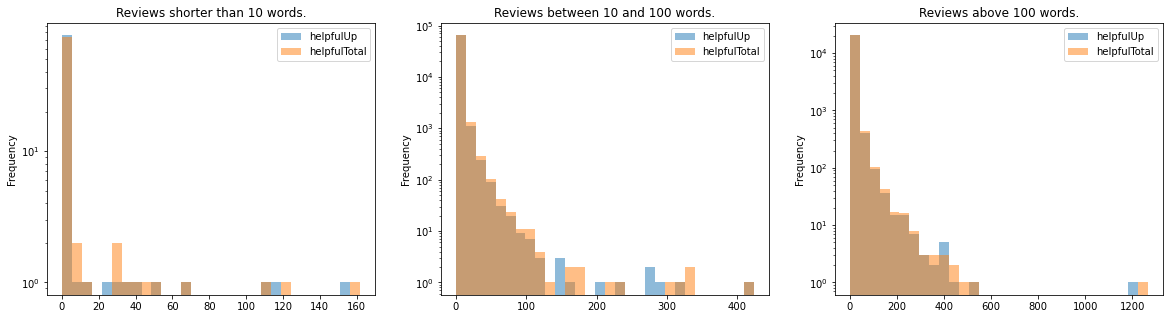

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
df[df.reviewTextLength < 10][["helpfulUp", "helpfulTotal"]].plot.hist(
    bins=30, log=True, alpha=0.5, ax=axes[0], title="Reviews shorter than 10 words."
)
df[(10 <= df.reviewTextLength) & (df.reviewTextLength < 100)][["helpfulUp", "helpfulTotal"]].plot.hist(
    bins=30, log=True, alpha=0.5, ax=axes[1], title="Reviews between 10 and 100 words."
)
df[df.reviewTextLength >= 100][["helpfulUp", "helpfulTotal"]].plot.hist(
    bins=30, log=True, alpha=0.5, ax=axes[2], title="Reviews above 100 words."
)
plt.show()

Lengths of the summaries are more well-distributed and summaries do not exceed 30 words.

count    87016.000000
mean         3.951308
std          2.719537
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         31.000000
Name: summaryLength, dtype: float64


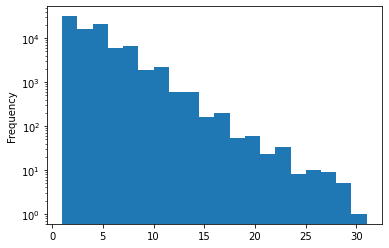

In [61]:
df.summaryLength.plot.hist(bins=20, log=True)
print(df.summaryLength.describe())

Before proceeding to next steps it is necessary to come up with a labeling system to extract the helpfulness label from the votes. I will select the most naive approach there the helpfulness score is simply computed as a division of upvotes by the total number of votes. This simple approach may have one drawback. Namely, it doesn't matter if the vote have 1 downvote or 100 downvotes the helpfulness score will be 0 for both of them. However at this stage I believe it won't have much negative impact on the rest of the analysis as 0 scored reviews are just considered to be unhelpful.

In [62]:
df['helpfulScore'] = df.helpfulUp / df.helpfulTotal
df.helpfulScore.fillna(-1, inplace=True)

C:\Users\pawel\AppData\Local\Temp\ipykernel_8644\914154797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['helpfulScore'] = df.helpfulUp / df.helpfulTotal
C:\Users\pawel\AppData\Local\Temp\ipykernel_8644\914154797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.helpfulScore.fillna(-1, inplace=True)


count    87016.000000
mean         0.779999
std          0.346826
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: helpfulScore, dtype: float64

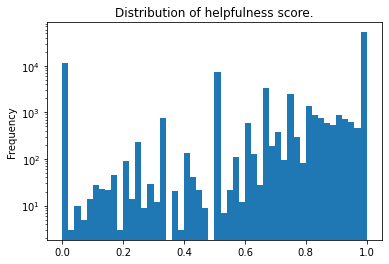

In [63]:
df = df[df.helpfulScore <= 1.0]  # filter out corrupted data
df.helpfulScore.plot.hist(bins=50, log=True, title="Distribution of helpfulness score.");
df.helpfulScore.describe()

There are clear peaks in this distribution at 0, 0.5 and 1. There appears to be one datapoint which is corrupted because the helpfulness score is 2.0 (means there is more upvotes than total votes) and it was filtered out. 

The majority of the reviwes gets rather positive score with the mean score at 0.78 which is pretty high. Because for the final modelling I need a binary label I will set the score threshold at 0.8 - meaning the review is exceptionally helpful. However in general case it would be worth investigating more on what does it mean for a review to be helpful and what is the objective of the system that is going to utilize the predictive model.

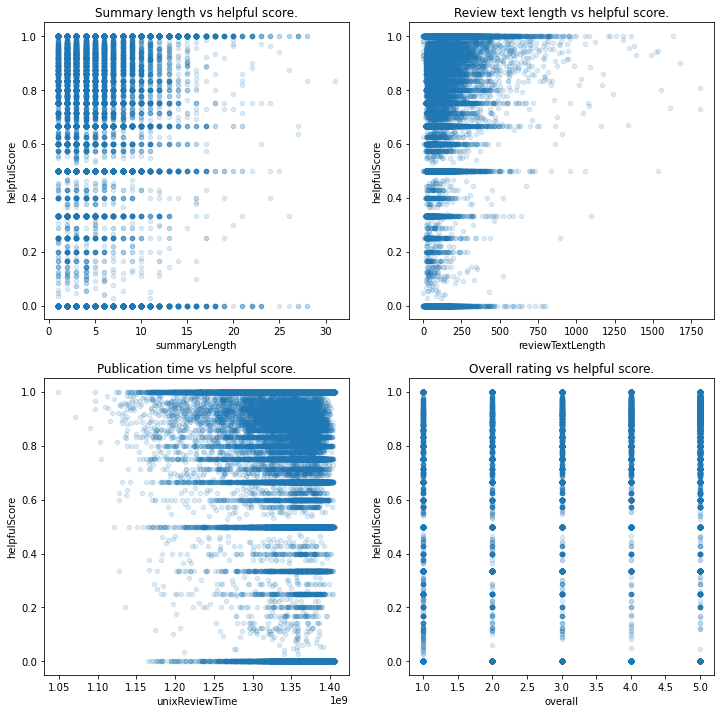

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
df.plot.scatter(
    'summaryLength', 'helpfulScore', alpha=0.15, ax=axes[0][0],
    title="Summary length vs helpful score."
)
df.plot.scatter(
    'reviewTextLength', 'helpfulScore', alpha=0.15, ax=axes[0][1],
    title="Review text length vs helpful score."
);
df.plot.scatter(
    'unixReviewTime', 'helpfulScore', alpha=0.15, ax=axes[1][0],
    title="Publication time vs helpful score."
);
df.plot.scatter(
    'overall', 'helpfulScore', alpha=0.15, ax=axes[1][1],
    title="Overall rating vs helpful score."
);

The main observations coming from the above charts are that longer reviews are more likely to get a high helpfulness score hence I think it is a good idea to keep the review and summary lengths as features. Interesting patterns appears on the right bottom plot where general helpfulness of the reviews seem to be degrading over time. However I don't think it is a good idea to use publication time of the review as the predictive feature as the time should not have impact on the content of the review. The last plot shows that helpfulness is uncorellated regarding the overall rating. For each of the ratings reviews were voted to be similarly helpful.

Equipped with those insigths into the data I will proceed to creating the helpfulness label and building predictive models.

In [65]:
df['isHelpful'] = df.helpfulScore.apply(lambda x: int(x > 0.8))

## Predictive models

The most basic approach I am going to use is classic machine learning linear SVM model with Tfidf features extracted from the reviews texts. I will also use review length as the feature as it seem to be positively correlated with the helpfulness of the reviews.

The dataset is not very well distibuted, this problem should be adressed in further work.

In [73]:
df.isHelpful.value_counts()

1    58087
0    28929
Name: isHelpful, dtype: int64

In [78]:
from sklearn.model_selection import train_test_split

# Train-test split.
train_reviews, test_reviews = train_test_split(df, random_state=42, test_size=0.33)
print("Fast check for train/test data distributions.")
print("Train set label mean: ", train_reviews.isHelpful.mean())
print("Test set label mean: ", test_reviews.isHelpful.mean())

Fast check for train/test data distributions.
Train set label mean:  0.6696912521440823
Test set label mean:  0.6631842875052236


In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


# Selection of the columns with features for the model. 
feature_columns = [
    'reviewText', 
    'summary', 
    'reviewTextLength', 
    'summaryLength',
    'overall',
]
X_train = train_reviews[feature_columns]
X_test = test_reviews[feature_columns]
y_train = train_reviews['isHelpful']
y_test = test_reviews['isHelpful']


model = LinearSVC(max_iter=1000, C=1.8)
tfidf_review_text = Pipeline([
    ('tfidf1', TfidfVectorizer(lowercase=True, max_df=0.7, use_idf=True)),
    ('chi2', SelectKBest(chi2, k=1000)),
])
tfidf_summary = Pipeline([
    ('tfidf1', TfidfVectorizer(lowercase=True, max_df=0.9, use_idf=True)),
    ('chi2', SelectKBest(chi2, k=1000)),
])
    
scaler = StandardScaler()

column_transformer = ColumnTransformer(
    [
        ('tfidf_review_text', tfidf_review_text, 'reviewText'), 
        ('tfidf_summary', tfidf_summary, 'summary'),
        ('lengths', scaler, ['reviewTextLength', 'summaryLength', 'overall']),
    ]
)

pipeline = Pipeline(
    [
        ('features', column_transformer),
        ('classier', model),
    ]
)

pipeline.fit(X_train, y_train)

C:\Users\pawel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('tfidf_review_text',
                                                  Pipeline(steps=[('tfidf1',
                                                                   TfidfVectorizer(max_df=0.7)),
                                                                  ('chi2',
                                                                   SelectKBest(k=1000,
                                                                               score_func=<function chi2 at 0x000001DC0E40ED30>))]),
                                                  'reviewText'),
                                                 ('tfidf_summary',
                                                  Pipeline(steps=[('tfidf1',
                                                                   TfidfVectorizer(max_df=0.9)),
                                                                  ('chi2',
                                                  

In [82]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score


pred_labels = pipeline.predict(X_test)
print('Mean predicted: ', pred_labels.mean())
print('f1_score: ', f1_score(y_test, pred_labels))
print('acc_score: ', accuracy_score(y_test, pred_labels))
print('roc_auc_score: ', roc_auc_score(y_test, pred_labels))

Mean predicted:  0.8777684914333472
f1_score:  0.7835932203389832
acc_score:  0.6665273715002089
roc_auc_score:  0.5483899307493734


The model performs almost randomly if we look at the `roc_auc_score`. 

## BERT Embedding

There are two possible appraches for solving the task using current state-of-the-art transformers. I will not implement any of those simply because I don't have the necessary computing power to make them work. BERT can be used as a classifier itself or as a embedding extractor. It is possible to use pre-trained model out of the box however it is strongly recommended to fine-tune it  for the downstream task which is classifying the helpfulness in our case.

The first possible solution is to use the BERT model to extract the classifying features from the text and then use them in simpler model. The input/output format of the BERT model enforces a `[CLS]` token at the beginning of the input and its embedding can be used for classifying tasks. The solution is to attach a heal MLP on top of the model and fine-tune the entire model end-to-end.

Below I present a runnable code that I prepared however I haven't managed to train the model becaue of time and computing resources limitations. The code was partialy taken from https://huggingface.co/docs/transformers/tasks/sequence_classification

In [83]:
from datasets import Dataset

df_bert = df[['reviewText', 'isHelpful']]
df_bert.columns = ['text', 'label']
amazon_dataset = Dataset.from_pandas(df_bert)
amazon_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 87016
})

In [84]:
amazon_dataset[0]

{'text': 'For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!',
 'label': 1,
 '__index_level_0__': 9}

In [85]:
from transformers import AutoTokenizer

# Use tokenized for DistilBERT model. It transforms subwords into tokens.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [86]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_reviews = amazon_dataset.map(preprocess_function, batched=True)

  0%|          | 0/88 [00:00<?, ?ba/s]

In [91]:
print("All tokenized reviews start with [CLS] token (101)")
for i in range(10):
    print(tokenized_reviews[i]['input_ids'][:20])

All tokenized reviews start with [CLS] token (101)
[101, 2005, 2054, 1045, 3825, 2005, 2048, 10722, 5809, 2003, 4895, 19442, 3085, 5973, 999, 1045, 3641, 1037, 5061, 1998]
[101, 2440, 1998, 2092, 26035, 2098, 1012, 2023, 10722, 8525, 2003, 1037, 3376, 6379, 3609, 2008, 3504, 2074, 2066, 1996]
[101, 25732, 6959, 1010, 1998, 2009, 2003, 3599, 2004, 2649, 1012, 1996, 2069, 3114, 1045, 2106, 2025, 2507, 2009, 1019]
[101, 1996, 3371, 1045, 2387, 2023, 2026, 2540, 16791, 1037, 3786, 1012, 2054, 1037, 3835, 2553, 2000, 4066, 2026, 3074]
[101, 2293, 2023, 11912, 3482, 2061, 2092, 2404, 2362, 4324, 20228, 10497, 2100, 1012, 1012, 1012, 2293, 1996, 5061, 1004]
[101, 2023, 3688, 2003, 2307, 2005, 3087, 2007, 1037, 2843, 1997, 11912, 2026, 6513, 2038, 1037, 2843, 1998, 2023, 5592]
[101, 1996, 4031, 2993, 2003, 2274, 3340, 1010, 2174, 1996, 6412, 2003, 28927, 1012, 1045, 18800, 2023, 4031, 1037, 2307]
[101, 1996, 2034, 3160, 2001, 2029, 7588, 2000, 16500, 2023, 2565, 1011, 3123, 5946, 2962, 2038, 1

In [87]:
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "notHelpful", 1: "helpful"}
label2id = {"notHelpful": 0, "helpful": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id, output_hidden_states=True
)

In [ ]:
training_args = TrainingArguments(
    output_dir="amazon_reviews_helpfulness",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_reviews,
    eval_dataset=tokenized_reviews,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

## Custom implementation on top of DistilBert

In [119]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

class AmznClassifier(nn.Module):
    def __init__(self, finetune_bert=False):
        super(AmznClassifier, self).__init__()
        self.finetune_bert = finetune_bert
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.distilbert.requires_grad_(finetune_bert)
        self.projection = nn.Linear(768, 2)
        
    def forward(self, inputs):
        embed = self._bert_embed(inputs)
        cls_embed = embed[:, 0, :]
        return self.projection(cls_embed)

    def _bert_embed(self, inputs):
        if finetune_bert:
            return self.distilbert(inputs, return_dict=True).last_hidden_state
        
        with torch.no_grad():
            return self.distilbert(inputs, return_dict=True).last_hidden_state

In [ ]:
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model = AmznClassifier()
model.train()

# for sample in tokenized_reviews:
for i in range(0, len(tokenized_reviews)//100, batch_size):
    loss = 0
    optimizer.zero_grad()
    
    for sample_id in range(i, i+batch_size):
        sample = tokenized_reviews[sample_id]
        inputs = torch.tensor(sample['input_ids']).unsqueeze(0)
        logits = model(inputs)
        loss += F.cross_entropy(logits, torch.tensor([sample['label']]))
        
    loss.backward()
    optimizer.step()
    print(f'{i+batch_size}/{len(tokenized_reviews)} done. Loss: {loss.item()}')

In [133]:
model.eval()

pred_labels = []
true_labels = []
for sample_id in range(len(tokenized_reviews)//50):
    sample = tokenized_reviews[sample_id]
    inputs = torch.tensor(sample['input_ids']).unsqueeze(0)
    logits = model(inputs)
    
    pred = F.softmax(logits, dim=1).max(1).indices[0].item()
    pred_labels.append(pred)
    true_labels.append(sample['label'])